In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/Applied Machine Learning/Cyrus Code/combined_data_with_y.csv' .

In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# specify the full path to the .pkl file
file_path = './combined_data_with_y.csv'

# read the csv file
df = pd.read_csv(file_path)

In [ ]:
df

,timestamp,open,high,low,close,vol,amount,year,month,day,ticker,y
0,2000-01-04,9.39,9.66,9.36,9.58,1091003.0,1.042001e+07,2000.0,1.0,4.0,600163,0.0
1,2000-01-05,9.58,10.10,9.55,9.76,4024920.0,3.973899e+07,2000.0,1.0,5.0,600163,0.0
2,2000-01-06,9.80,10.12,9.60,10.12,3590668.0,3.573042e+07,2000.0,1.0,6.0,600163,0.0
3,2000-01-07,10.12,10.23,9.88,10.10,2414875.0,2.432792e+07,2000.0,1.0,7.0,600163,0.0
4,2000-01-10,10.10,10.40,9.83,10.08,2457994.0,2.479926e+07,2000.0,1.0,10.0,600163,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14990076,2024-09-23,3.50,3.54,3.49,3.50,3155600.0,1.109216e+07,2024.0,9.0,23.0,2688,0.0
14990077,2024-09-24,3.53,3.63,3.52,3.63,6833900.0,2.446263e+07,2024.0,9.0,24.0,2688,0.0
14990078,2024-09-25,3.65,3.74,3.65,3.67,6645900.0,2.456506e+07,2024.0,9.0,25.0,2688,0.0
14990079,2024-09-26,3.67,3.80,3.66,3.79,6527600.0,2.437135e+07,2024.0,9.0,26.0,2688,0.0


In [ ]:
df['y'].unique()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
# Convert 'y' column to 0/1 classes
df['y'] = df['y'].apply(lambda x: 1 if x > 0 else 0)
df['y'].unique()

array([0, 1])

In [ ]:
X = df[['open', 'high', 'low', 'close', 'vol', 'amount', ]]
y = df['y']

In [ ]:
# Split data into training, validation, and testing sets
# 60-20-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1) # Reshape for binary classification
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([8994048, 6])
y_train shape: torch.Size([8994048, 1])
X_val shape: torch.Size([2998016, 6])
y_val shape: torch.Size([2998016, 1])
X_test shape: torch.Size([2998017, 6])
y_test shape: torch.Size([2998017, 1])


In [ ]:
# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader
batch_size = 2**20  # Choose an appropriate batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [ ]:
# Instantiate the model
input_size = X_train.shape[1]  # Number of features
hidden_size1 = 64
hidden_size2 = 32
output_size = 1  # Binary classification
model = MLP(input_size, hidden_size1, hidden_size2, output_size).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Implement a training loop with validation set storing the best model parameters
num_epochs = 10
best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(val_loader):
            data, target = data.to(device), target.to(device)
            val_outputs = model(data)
            val_loss = criterion(val_outputs, target)
            if val_loss < best_val_loss:
              best_val_loss = val_loss
              best_model_state = deepcopy(model.state_dict())

    if (epoch+1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

model.load_state_dict(best_model_state)

9it [02:21, 15.75s/it]
100%|██████████| 3/3 [00:40<00:00, 13.65s/it]


Epoch [1/10], Train Loss: 0.6115, Val Loss: 0.6036


9it [02:15, 15.10s/it]
100%|██████████| 3/3 [00:42<00:00, 14.14s/it]


Epoch [2/10], Train Loss: 0.5420, Val Loss: 0.5342


9it [02:17, 15.23s/it]
100%|██████████| 3/3 [00:44<00:00, 14.69s/it]


Epoch [3/10], Train Loss: 0.4679, Val Loss: 0.4591


9it [02:13, 14.86s/it]
100%|██████████| 3/3 [00:43<00:00, 14.35s/it]


Epoch [4/10], Train Loss: 0.3866, Val Loss: 0.3768


9it [02:17, 15.28s/it]
100%|██████████| 3/3 [00:43<00:00, 14.33s/it]


Epoch [5/10], Train Loss: 0.3046, Val Loss: 0.2962


9it [02:15, 15.05s/it]
100%|██████████| 3/3 [00:42<00:00, 14.27s/it]


Epoch [6/10], Train Loss: 0.2390, Val Loss: 0.2326


9it [02:17, 15.25s/it]
100%|██████████| 3/3 [00:39<00:00, 13.24s/it]


Epoch [7/10], Train Loss: 0.1958, Val Loss: 0.1917


9it [02:16, 15.19s/it]
100%|██████████| 3/3 [00:42<00:00, 14.11s/it]


Epoch [8/10], Train Loss: 0.1728, Val Loss: 0.1704


9it [02:16, 15.21s/it]
100%|██████████| 3/3 [00:39<00:00, 13.29s/it]


Epoch [9/10], Train Loss: 0.1628, Val Loss: 0.1608


9it [02:17, 15.31s/it]
100%|██████████| 3/3 [00:41<00:00, 13.83s/it]


Epoch [10/10], Train Loss: 0.1585, Val Loss: 0.1565


100%|██████████| 3/3 [00:43<00:00, 14.50s/it]

Test Accuracy: 0.9684


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Applied Machine Learning/Cyrus Code/MLP.pth')

In [ ]:
predicted = []

model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0

    for data, target in tqdm(test_loader):  # Iterate over test_loader
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted.append((outputs > 0.5).float())
        total_correct += (predicted[-1] == target).sum().item()
        total_samples += target.size(0)

    accuracy = total_correct / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")

predicted = torch.cat(predicted)

100%|██████████| 3/3 [00:43<00:00, 14.43s/it]

Test Accuracy: 0.9684


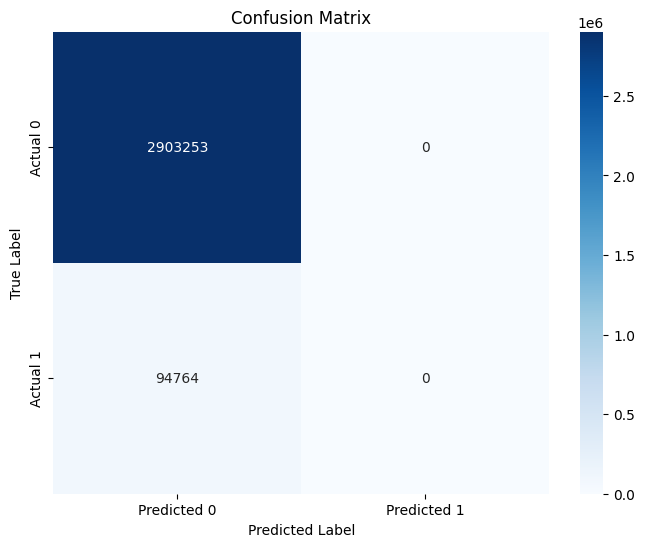

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98   2903253
         1.0       0.00      0.00      0.00     94764

    accuracy                           0.97   2998017
   macro avg       0.48      0.50      0.49   2998017
weighted avg       0.94      0.97      0.95   2998017



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for sklearn functions
y_pred = predicted.cpu().numpy().flatten()
y_true = y_test.cpu().numpy().flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Classification Report (Precision, Recall, F1-score, Support)
print(classification_report(y_true, y_pred))